
- Train models for multiple IoT devices

Useful links:
- dataset https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant#

In [1]:
%load_ext autotime
# https://github.com/cpcloud/ipython-autotime

time: 255 µs (started: 2021-06-09 21:56:45 +02:00)


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from mlflow.tracking import MlflowClient

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

np.random.seed(42)

plt.rcParams['figure.figsize'] = [10, 7]

time: 1.02 ms (started: 2021-06-09 22:19:18 +02:00)


/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
filepath = "../../data/power_plant/power_plant.csv"
target_column = "PE"
feature_column_list = ["AT", "V", "AP", "RH"]
device_id_column = "device_id"

time: 368 µs (started: 2021-06-09 21:56:48 +02:00)


/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

experiment_name = "retraining_pipeline_dsp"

mlflow.set_experiment(experiment_name)

experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
experiment_id

'1'

time: 52 ms (started: 2021-06-09 21:56:48 +02:00)


In [5]:
df = pd.read_csv(filepath)
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


time: 40.8 ms (started: 2021-06-09 21:56:48 +02:00)


- The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011). Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) **to predict the net hourly electrical energy output (EP) of the plant**.

- Features consist of hourly average ambient variables
    - **T**: Temperature
    - **AP**: Ambient Pressure
    - **RH**: Relative Humidity
    - **V**: Exhaust Vacuum
    - **EP**: Net hourly electrical energy output

- The averages are taken from various sensors located around the plant that record the ambient variables every second. 

- Add a new column `device_id` to create 4 different IoT devices.

In [6]:
df["device_id"] = np.random.randint(0, 4, size=len(df))
df.sample(5)

/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,AT,V,AP,RH,PE,device_id
7117,21.53,52.84,1005.06,88.22,444.04,0
17209,7.61,44.71,1019.41,70.48,485.36,0
25622,15.25,52.90,1014.86,76.87,463.93,1
24430,23.91,50.23,1017.25,68.57,455.41,0
25740,30.74,79.05,1005.78,73.19,430.69,1


time: 13.3 ms (started: 2021-06-09 21:56:48 +02:00)


In [7]:
df.device_id.value_counts()

/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    12081
3    11995
2    11897
1    11867
Name: device_id, dtype: int64

time: 6.3 ms (started: 2021-06-09 21:56:48 +02:00)


<AxesSubplot:>

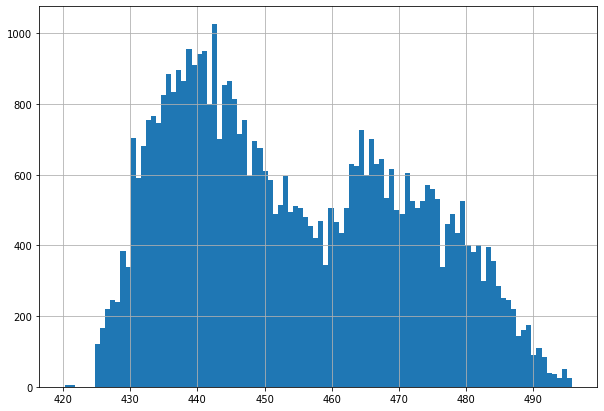

time: 408 ms (started: 2021-06-09 21:56:48 +02:00)


In [8]:
df[target_column].hist(bins=100)

In [9]:
#df[df[device_id_column] == 0][target_column].hist(bins=100)

time: 264 µs (started: 2021-06-09 21:56:48 +02:00)


# Model training

In [10]:
def train_device_model(device_df, run_id, experiment_id, month_to_log):
    """ Train a model for a single IoT device"""
    
    device_id = device_df[device_id_column].iloc[0]
    
    #with mlflow.start_run(run_id=run_id):
    # Create a nested run for the specific device
    with mlflow.start_run(experiment_id=experiment_id, run_name=str(device_id), nested=True) as nested_run:

        mlflow.autolog(log_input_examples=True)

        # Pull metadata
        mlflow.log_param("device_id", device_id)
        mlflow.log_param("month", month_to_log)

        num_instances = len(device_df)
        mlflow.log_param("num_instances", num_instances)

        # Split data
        X = device_df[["AT", "V", "AP", "RH"]]
        y = device_df["PE"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Track data info as params
        num_training = len(X_train)
        mlflow.log_param("num_training", num_training)
        num_test = len(X_test)
        mlflow.log_param("num_test", num_test)

        # Fit model
        rf = RandomForestRegressor()
        rf.fit(X_train, y_train)

        # Evaluate the model
        predictions = rf.predict(X_test)
        test_mse = mean_squared_error(y_test, predictions)
        mlflow.log_metric("test_mse", test_mse)

        # Return run metadata
        artifact_uri = f"runs:/{nested_run.info.run_id}/model"
        nested_run_id = nested_run.info.run_id


        # Create a return pandas DataFrame
        ret_df = {
            "device_id": device_id,
            "run_id": run_id,
            "num_instances": num_instances,
            "num_training": num_training,
            "num_test": num_test,
            "model_path": artifact_uri,
            "test_mse": test_mse

        }
    return test_mse

time: 1.59 ms (started: 2021-06-09 21:56:48 +02:00)


In [11]:
#df.groupby(device_id_column).apply(train_device_model)

time: 419 µs (started: 2021-06-09 21:56:48 +02:00)


In [12]:
#for device_id in range(4):
#    train_device_model(df[df[device_id_column] == device_id])

time: 890 µs (started: 2021-06-09 21:56:48 +02:00)


In [60]:
from multiprocessing import Pool
from functools import partial

def mapped_training(run_name, training_df, month):
    """ Apply mapped training with MLflow tracking """
    
    with mlflow.start_run(run_name=run_name) as run:

        mlflow.autolog()
    
        # Track anything to parent run here
        mlflow.log_param("month", month)
        mlflow.log_param("total_instances_all_devices", training_df.count())

        month_to_log = month
        run_id = run.info.run_id
        experiment_id = run.info.experiment_id
        
        # Prepare data and execute model
        pool = Pool()
        
        device_df_list = [training_df[training_df[device_id_column] == device_id] for device_id in range(4)]
        mapped_results_dict_list = pool.map(
            partial(train_device_model, run_id=run_id, experiment_id=experiment_id, month_to_log=month_to_log),
            device_df_list
        )

    return mapped_results_dict_list

time: 2.13 ms (started: 2021-06-09 22:28:51 +02:00)


/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
mapped_training("month_1", df, month=1)

2021/06/09 22:09:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:09:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:09:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:09:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:09:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


[4.8642669505378775, 5.396214081179497, 5.011336795449574, 4.544762642050846]

time: 4.28 s (started: 2021-06-09 22:09:39 +02:00)


# Data shift

In [18]:
df_lower_distribution = df[df["PE"] < 470]

# Create 2 "months" worth of data from the same distribution
mask = np.random.rand(len(df_lower_distribution)) < 0.5
df_1, df_2 = df_lower_distribution[mask], df_lower_distribution[~mask]

time: 6.25 ms (started: 2021-06-09 22:01:27 +02:00)


/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

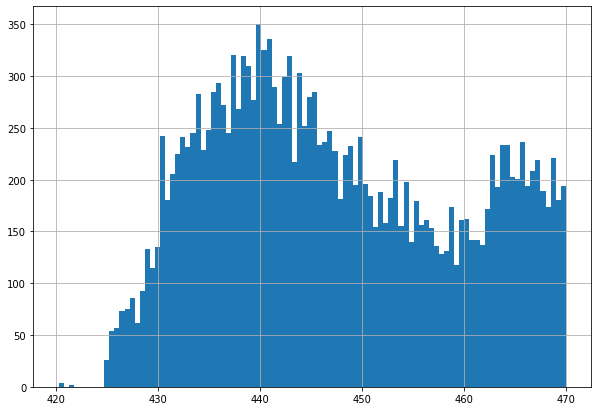

time: 814 ms (started: 2021-06-09 22:01:49 +02:00)


In [21]:
df_1[target_column].hist(bins=100)

<AxesSubplot:>

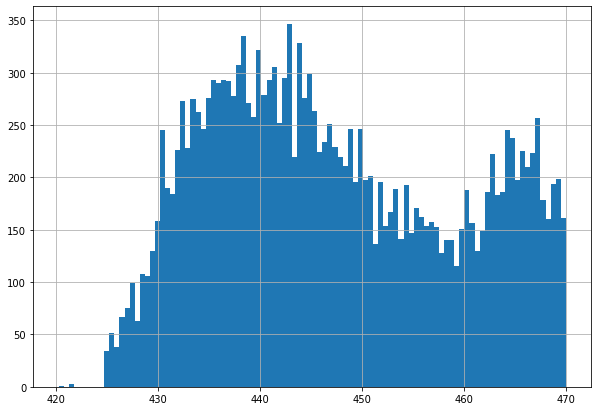

time: 266 ms (started: 2021-06-09 22:01:56 +02:00)


In [22]:
df_2[target_column].hist(bins=100)

/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

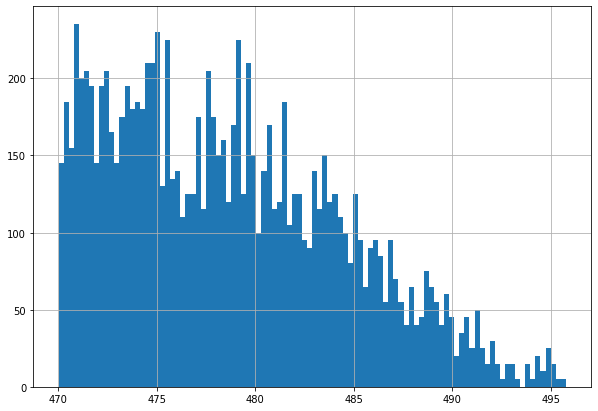

time: 266 ms (started: 2021-06-09 22:03:02 +02:00)


In [25]:
df_3 = df[df["PE"] >= 470]
df_3["PE"].hist(bins=100)

# Retraining

## Month 1

In [26]:
run_name = "month_1"

month_1_df = df_1

mapped_results_1 = mapped_training(run_name, month_1_df, month=1)
mapped_results_1

/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021/06/09 22:04:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:04:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:04:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:04:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:04:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


[7.991769596934798, 7.692271685135422, 7.887024664352049, 7.143787195359727]

time: 1.99 s (started: 2021-06-09 22:04:53 +02:00)


## Register and transition model

### Register model

In [41]:
def register_model_by_device_id(experiment_id, device_id):
    """
    Register model from most recent MLflow run by device_id

    returns Single mlflow.entities.model_registry.ModelVersion object created by backend
    """
    # Get run id for most recent run for given device
    run_id = mlflow.search_runs(experiment_id,
                                order_by=['attributes.start_time desc'],
                                filter_string=f"params.device_id = '{device_id}'").iloc[0]["run_id"]

    model_version = mlflow.register_model(model_uri=f"runs:/{run_id}/model", name=f"powerplant_device_{device_id}")

    return model_version

time: 567 µs (started: 2021-06-09 22:15:29 +02:00)


In [43]:
month_1_model_version_0 = register_model_by_device_id(experiment_id, device_id=0)
month_1_model_version_1 = register_model_by_device_id(experiment_id, device_id=1)
month_1_model_version_2 = register_model_by_device_id(experiment_id, device_id=2)
month_1_model_version_3 = register_model_by_device_id(experiment_id, device_id=3)

Registered model 'powerplant_device_0' already exists. Creating a new version of this model...
2021/06/09 22:16:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_0, version 2
Created version '2' of model 'powerplant_device_0'.
Successfully registered model 'powerplant_device_1'.
2021/06/09 22:16:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_1, version 1
Created version '1' of model 'powerplant_device_1'.
Successfully registered model 'powerplant_device_2'.
2021/06/09 22:16:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_2, version 1
Created version '1' of model 'powerplant_device_2'.
Successfully registered model 'powerplant_device_3'.
2021/06/09 22:

time: 359 ms (started: 2021-06-09 22:16:18 +02:00)


Created version '1' of model 'powerplant_device_3'.


### Transition model

In [44]:
def transition_model(model_version, stage):
    """
    Transition a model to a specified stage in MLflow Model Registry using the associated
    mlflow.entities.model_registry.ModelVersion object.

    :param model_version: mlflow.entities.model_registry.ModelVersion. ModelVersion object to transition
    :param stage: (str) New desired stage for this model version. One of "Staging" or "Production"

    :return: A single mlflow.entities.model_registry.ModelVersion object
    """
    client = MlflowClient()
    
    model_version = client.transition_model_version_stage(
        name=model_version.name,
        version=model_version.version,
        stage=stage,
        archive_existing_versions=False
    )

    return model_version

time: 459 µs (started: 2021-06-09 22:17:50 +02:00)


In [47]:
month_1_model_version_0 = transition_model(month_1_model_version_0, stage="Production")

time: 50.6 ms (started: 2021-06-09 22:22:44 +02:00)


In [48]:
month_1_model_version_0 = transition_model(month_1_model_version_0, stage="Production")
month_1_model_version_1 = transition_model(month_1_model_version_1, stage="Production")
month_1_model_version_2 = transition_model(month_1_model_version_2, stage="Production")
month_1_model_version_3 = transition_model(month_1_model_version_3, stage="Production")

time: 94.3 ms (started: 2021-06-09 22:22:57 +02:00)


## Month 2

In [66]:
mapped_training("month_2", df, month=2)

/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021/06/09 22:33:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:33:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:33:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:33:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:33:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


[4.8293869776706515, 5.310079966819747, 4.967665792605043, 4.548094371150494]

time: 5.37 s (started: 2021-06-09 22:33:42 +02:00)


In [67]:
# Register
month_2_model_version_0 = register_model_by_device_id(experiment_id, device_id=0)
month_2_model_version_1 = register_model_by_device_id(experiment_id, device_id=1)
month_2_model_version_2 = register_model_by_device_id(experiment_id, device_id=2)
month_2_model_version_3 = register_model_by_device_id(experiment_id, device_id=3)

/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Registered model 'powerplant_device_0' already exists. Creating a new version of this model...
2021/06/09 22:34:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_0, version 3
Created version '3' of model 'powerplant_device_0'.
Registered model 'powerplant_device_1' already exists. Creating a new version of this model...
2021/06/09 22:34:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_1, ve

time: 451 ms (started: 2021-06-09 22:34:07 +02:00)


Created version '2' of model 'powerplant_device_3'.


In [68]:
# Transition to Staging
month_2_model_version_0 = transition_model(month_2_model_version_0, stage="Staging")
month_2_model_version_1 = transition_model(month_2_model_version_1, stage="Staging")
month_2_model_version_2 = transition_model(month_2_model_version_2, stage="Staging")
month_2_model_version_3 = transition_model(month_2_model_version_3, stage="Staging")

time: 51.6 ms (started: 2021-06-09 22:34:16 +02:00)


In [69]:
####################################################################################

# Run models through testing and validation prior to transitioning to Production

####################################################################################

time: 231 µs (started: 2021-06-09 22:34:27 +02:00)


In [70]:
# Transition to Production
month_2_model_version_0 = transition_model(month_2_model_version_0, stage="Production")
month_2_model_version_1 = transition_model(month_2_model_version_1, stage="Production")
month_2_model_version_2 = transition_model(month_2_model_version_2, stage="Production")
month_2_model_version_3 = transition_model(month_2_model_version_3, stage="Production")

time: 63.1 ms (started: 2021-06-09 22:34:42 +02:00)


## Month 3

In [72]:
mapped_training("month_2", df, month=2)

/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021/06/09 22:35:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:35:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:35:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:35:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2021/06/09 22:35:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


[4.8293869776706515, 5.310079966819747, 4.967665792605043, 4.548094371150494]

time: 4.88 s (started: 2021-06-09 22:35:26 +02:00)


In [73]:
# Register
month_3_model_version_0 = register_model_by_device_id(experiment_id, device_id=0)
month_3_model_version_1 = register_model_by_device_id(experiment_id, device_id=1)
month_3_model_version_2 = register_model_by_device_id(experiment_id, device_id=2)
month_3_model_version_3 = register_model_by_device_id(experiment_id, device_id=3)

/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Registered model 'powerplant_device_0' already exists. Creating a new version of this model...
2021/06/09 22:35:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_0, version 4
Created version '4' of model 'powerplant_device_0'.
Registered model 'powerplant_device_1' already exists. Creating a new version of this model...
2021/06/09 22:35:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_1, ve

time: 687 ms (started: 2021-06-09 22:35:48 +02:00)


Created version '3' of model 'powerplant_device_3'.


In [75]:
# Transition to Staging
month_3_model_version_0 = transition_model(month_3_model_version_0, stage="Staging")
month_3_model_version_1 = transition_model(month_3_model_version_1, stage="Staging")
month_3_model_version_2 = transition_model(month_3_model_version_2, stage="Staging")
month_3_model_version_3 = transition_model(month_3_model_version_3, stage="Staging")

time: 48.3 ms (started: 2021-06-09 22:35:57 +02:00)


In [76]:
####################################################################################

# Run models through testing and validation prior to transitioning to Production

####################################################################################

time: 188 µs (started: 2021-06-09 22:36:11 +02:00)


In [77]:
# Transition to Production
month_3_model_version_0 = transition_model(month_3_model_version_0, stage="Production")
month_3_model_version_1 = transition_model(month_3_model_version_1, stage="Production")
month_3_model_version_2 = transition_model(month_3_model_version_2, stage="Production")
month_3_model_version_3 = transition_model(month_3_model_version_3, stage="Production")

time: 48.2 ms (started: 2021-06-09 22:36:24 +02:00)


## Metrics monitoring

In [64]:
def get_registered_model_runs(device_id, stage="Production"):
    """
    Get the original runs for a given device id, which have been registered to an original stage

    Returns a list of mlflow.entities.Run objects corresponding to original runs
    """
    client = MlflowClient()

    registry_model_name = f"powerplant_device_{device_id}"
    filter_string = f"name='{registry_model_name}'"
    model_versions = client.search_model_versions(filter_string=filter_string)
    prod_run_ids = [model_version.run_id for model_version in model_versions if model_version.current_stage==stage]
    prod_original_runs = [client.get_run(run_id) for run_id in prod_run_ids]

    return prod_original_runs

time: 618 µs (started: 2021-06-09 22:30:34 +02:00)


In [58]:
def get_metric_over_months_pdf(device_id, stage="Production", metric="test_mse"):
    device_prod_runs = get_registered_model_runs(device_id, stage=stage)
    
    metrics = [run.data.metrics[metric] for run in device_prod_runs]
    months = [run.data.params["month"] for run in device_prod_runs]
    metric_months_pdf = pd.DataFrame({
        metric:metrics, "month":months, "device_id":[device_id]*len(metrics)
    }).sort_values("month")

    return metric_months_pdf

time: 756 µs (started: 2021-06-09 22:27:48 +02:00)


In [61]:
metric_over_months_pdf = pd.concat([
    get_metric_over_months_pdf(device_id, metric="test_mse") for device_id in range(4)
])
metric_over_months_pdf

,test_mse,month,device_id
0,4.864267,1,0
0,5.396214,1,1
0,5.011337,1,2
0,4.544763,1,3


time: 127 ms (started: 2021-06-09 22:29:15 +02:00)


In [62]:
def plot_metric_over_months(device_prod_runs, metric="test_mse"):
    """
    Return figure
    """
    metrics = [run.data.metrics[metric] for run in device_prod_runs]
    months = [run.data.params["month"] for run in device_prod_runs]
    metric_months_pdf = pd.DataFrame({metric:metrics, "month":months}).sort_values("month")

    return metric_months_pdf.plot.line(x="month", y=metric)

time: 601 µs (started: 2021-06-09 22:30:05 +02:00)


/Users/alaa.bakhti/miniconda3/envs/dsp/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


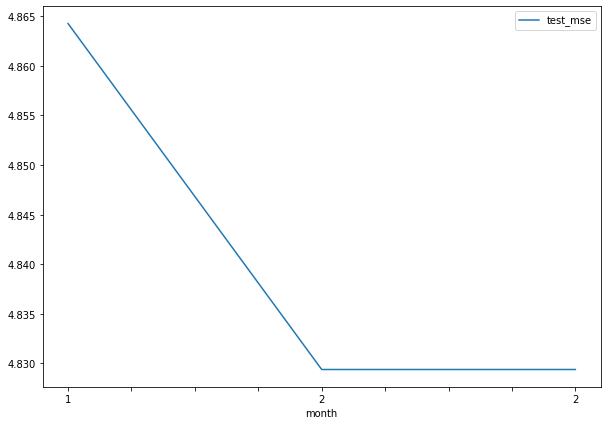

time: 211 ms (started: 2021-06-09 22:36:35 +02:00)


In [78]:
device_id = 0
stage = "Production"
metric = "test_mse"

device_prod_runs = get_registered_model_runs(device_id, stage=stage)
fig = plot_metric_over_months(device_prod_runs, metric=metric)